# Logistic Regression

#### We start from importing our required lybraries like pandas, numpy, tensorflow, pylot, CountVectorizer, classification_report

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report


##### Firstly we split our dataset in esential piecis of x/ytrain and x/ytest data. Then we apply vocabulary paramiters the values of m, n, k words are the result of an expirimiteng algorithm at the end of this file

In [3]:
m = 3000   
n = 200    
k = 80      
infogain = False
g = 800 

(x_train_imdb, y_train_imdb), (x_test_imdb, y_test_imdb) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])




#### We need to convert our x test/train data in a binary form so we use CountVectorizer

In [4]:
binary_vectorizer = CountVectorizer(binary=True)
x_train_imdb_binary = binary_vectorizer.fit_transform(x_train_imdb)
x_test_imdb_binary = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)

x_train_imdb_binary = x_train_imdb_binary.toarray()
x_test_imdb_binary = x_test_imdb_binary.toarray()

Vocabulary size: 2677


#### This is an implementation of imformation gain, in this algorithm the aplication of IG has none or a sligth effect in the logistic Regression's metrics so we dont use it mutch

In [5]:
from math import log 

if  infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0 # Αρχικοποίηση της εντροπίας του χαρακτηριστικού Hc_feature.
    for feat in feature_values:
      
      # Υπολογισμός του P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          # Υπολογισμός του P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # Υπολογισμός του - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    # Υπολογισμός του information gain.
    ig = Hc - Hc_feature
    return ig

  # Επιλογή των g πιο σημαντικών χαρακτηριστικών.
  ig = [(i, IG(y_train_imdb, x_train_imdb_binary[:, i])) for i in range(len(x_train_imdb_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]
  # Προσαρμογή των δεδομένων εκπαίδευσης και ελέγχου.
  x_train_binary = x_train_imdb_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_imdb_binary[:, [i[0] for i in ig]]

##### Logistic Regression algorithm.
##### Best model parameters are 0.1 for lambda_value, 100 for max_iter and 0.001 for eta. In this implementation we use gradient ascent , we try to reach the global maxima by mooving slowly torwards uphill as a result we maximize the cost function in order to fit our model. Nececerly  to train the model we apply the gradient to the weights multiplied by the eta value. The main idea of this algorithm is to predict the outpout with the help of the sigmoid function and the threshold.

In [6]:
class LogisticRegression:
    def __init__(self, lambda_value = 0.1, max_iter = 100,eta=0.001):
        self.lambda_value = lambda_value
        self.max_iter = max_iter
        self.weights = None
        self.regularization = 0
        self.eta = eta

   
         

    def fit(self, X, y):
        samples = X.shape[0]
        features = X.shape[1]
        self.weights = np.zeros(features)

        for t in range(self.max_iter):
            linear = np.dot(X, self.weights) 
            y_pred = self.sigmoid(linear)

            gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-self.lambda_value*sum(self.weights**2)
            
            self.weights += self.eta * gradient_ascent
                  
            
           
    def predict(self, X):
        linear = np.dot(X, self.weights)
        y_pred = self.sigmoid(linear)
        y_pred_classes = [1 if i>0.5 else 0 for i in y_pred]
        return y_pred_classes
    
    def sigmoid(self, t):
        return 1 / (1 + np.exp(-t))

### Classification report

In [7]:
log = LogisticRegression()

log.fit(x_train_imdb_binary, y_train_imdb)
print(classification_report(y_test_imdb,log.predict(x_test_imdb_binary)))


              precision    recall  f1-score   support

           0       0.81      0.86      0.83     12500
           1       0.85      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



### Classification table

In [8]:
from visualizations import *

data = classification_data(LogisticRegression(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)


data_table = classification_table(data,x_train_imdb_binary)
ipd.display(data_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.82,0.79,0.76,0.73,0.95,0.93,0.84,0.82
10000,0.84,0.82,0.81,0.80,0.89,0.87,0.85,0.83
15000,0.84,0.83,0.83,0.82,0.85,0.84,0.84,0.83
20000,0.84,0.83,0.82,0.81,0.86,0.85,0.84,0.83
25000,0.83,0.83,0.85,0.85,0.81,0.79,0.83,0.82


###

In [9]:
from visualizations import *


Eta=[0.01, 0.001]
L=[1, 0.1, 0.01, 0.001]
iter=[1000,100,50]
maxAccuracy = -float('inf')


for h,l,it in zip(Eta,L,iter):
    log.eta=h
    log.lambda_value=l
    log.max_iter=it
    log.fit(x_train_imdb_binary,y_train_imdb)
    c_accuracy=accuracy_score(y_test_imdb,log.predict(x_test_imdb_binary))
    if(c_accuracy>maxAccuracy):
        maxAccuracy = c_accuracy
        bestl=l
        besth=h
        bestIter=it

print(bestl)
print(besth)
print(bestIter)

C:\Users\stamc\AppData\Local\Temp\ipykernel_11492\913407241.py:34: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-t))
C:\Users\stamc\AppData\Local\Temp\ipykernel_11492\913407241.py:21: RuntimeWarning: overflow encountered in square
  gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-self.lambda_value*sum(self.weights**2)


0.1
0.001
100


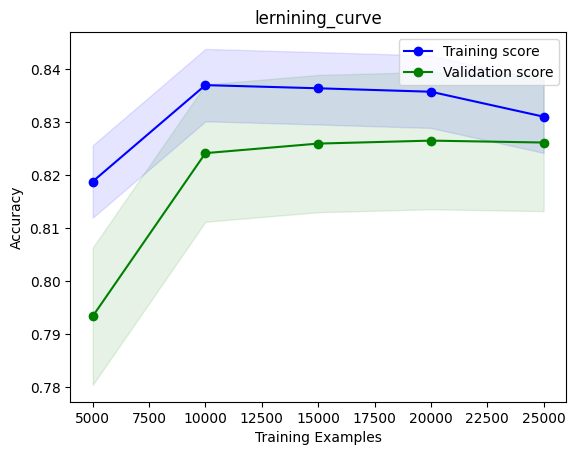

In [16]:
plot_learning_curve(data,"lernining_curve",False,'accuracy',"Accuracy")

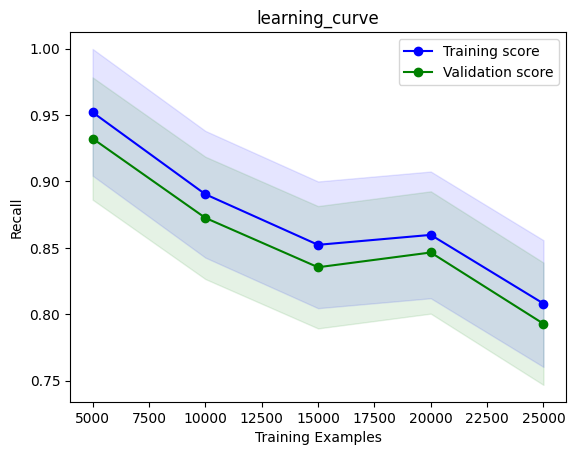

In [17]:
plot_learning_curve(data,"learning_curve",False,'recall',"Recall")

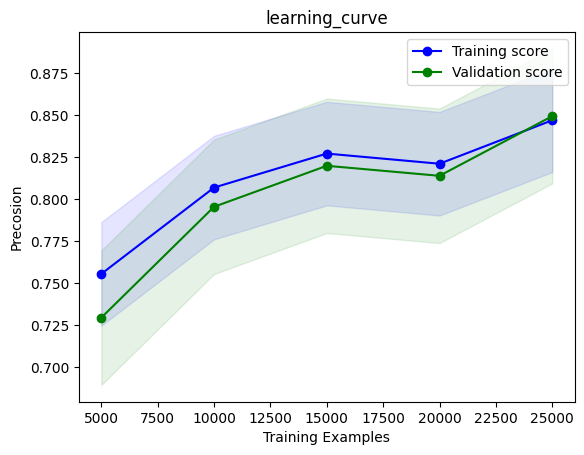

In [12]:
plot_learning_curve(data,"learning_curve",False,'precision',"Precosion")

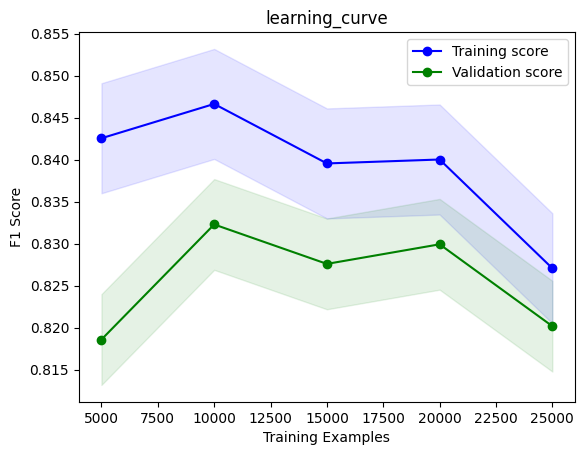

In [13]:
plot_learning_curve(data,"learning_curve",False,'f1',"F1 Score")

In [15]:
from sklearn.linear_model import LogisticRegression

logistic_data = classification_data(LogisticRegression(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)
logistic_data['estimator'] = 'SKLogisticRegression'
logistic_table = classification_table(logistic_data,x_train_imdb_binary)
difference_table = abs(logistic_table - data_table)
difference_table = difference_table.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=data['estimator'], estimator_2=logistic_data['estimator']))
ipd.display(difference_table)

c:\Users\stamc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\stamc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.170000,0.030000,0.230000,0.090000,0.040000,0.100000,0.150000,0.000000
10000,0.120000,0.010000,0.150000,0.030000,0.070000,0.030000,0.110000,0.000000
15000,0.090000,0.010000,0.100000,0.020000,0.090000,0.000000,0.090000,0.010000
20000,0.080000,0.020000,0.100000,0.030000,0.070000,0.000000,0.080000,0.020000
25000,0.080000,0.020000,0.060000,0.010000,0.110000,0.060000,0.080000,0.030000


In [ ]:

N = [50, 100, 200, 300]
K = [20, 50, 80]
M = [2000, 2500, 3000]

binary_vectorizer = CountVectorizer(binary=True)
minK = 0
minN = 0
minM = 0
maxAccuracy = -float('inf')

for m in M:
    for n in N:
        for k in K:
            (x_trainn, y_trainn), (x_testt, y_testt) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
            word_index = tf.keras.datasets.imdb.get_word_index()

            index2word = dict((i + 3, word) for (word, i) in word_index.items())
            index2word[0] = '[pad]'
            index2word[1] = '[bos]'
            index2word[2] = '[oov]'

            x_trainn = np.array([' '.join([index2word[idx] for idx in text]) for text in x_trainn])
            x_testt = np.array([' '.join([index2word[idx] for idx in text]) for text in x_testt])

            x_trainn_binary = binary_vectorizer.fit_transform(x_trainn)
            x_testt_binary = binary_vectorizer.transform(x_testt)

            x_trainn_binary = np.array(x_trainn_binary.toarray())
            x_testt_binary = np.array(x_testt_binary.toarray())

            
            log. fit(x_trainn_binary, y_trainn)
            predicted_values = log.predict(x_testt_binary)
            print("For M={}, N={} and K={}:".format(m, n, k))
            acc = accuracy_score(y_testt, predicted_values)
            print('Accuracy:', acc)
            if acc > maxAccuracy:
                maxAccuracy = acc
                minN = n
                minK = k
                minM = m

print("\nBest model parameters are:\n\tN: {}\n\tK:{} \n\tM: {}".format(minN, minK, minM))



For M=2000, N=50 and K=20:
Accuracy: 0.7324
For M=2000, N=50 and K=50:
Accuracy: 0.73244
For M=2000, N=50 and K=80:
Accuracy: 0.73184
For M=2000, N=100 and K=20:
Accuracy: 0.77264
For M=2000, N=100 and K=50:
Accuracy: 0.77248
For M=2000, N=100 and K=80:
Accuracy: 0.7718
For M=2000, N=200 and K=20:
Accuracy: 0.82232
For M=2000, N=200 and K=50:
Accuracy: 0.82204
For M=2000, N=200 and K=80:
Accuracy: 0.82196
For M=2000, N=300 and K=20:
Accuracy: 0.8182
For M=2000, N=300 and K=50:
Accuracy: 0.8182
For M=2000, N=300 and K=80:
Accuracy: 0.8172
For M=2500, N=50 and K=20:
Accuracy: 0.7348
For M=2500, N=50 and K=50:
Accuracy: 0.73476
For M=2500, N=50 and K=80:
Accuracy: 0.73448
For M=2500, N=100 and K=20:
Accuracy: 0.7754
For M=2500, N=100 and K=50:
Accuracy: 0.7754
For M=2500, N=100 and K=80:
Accuracy: 0.77524
For M=2500, N=200 and K=20:
Accuracy: 0.82576
For M=2500, N=200 and K=50:
Accuracy: 0.82548
For M=2500, N=200 and K=80:
Accuracy: 0.82492
For M=2500, N=300 and K=20:
Accuracy: 0.82096
Fo